Data scraped on 01_03_24 so there has been 3 months of data since the sale. I will filter out sales after the december sale date. unfortunelty the basic form dfs cant be filtered but there will have been very limited change over the winter (cases like nadia glory are few and far between). I will in time have the full data set scraped but there is no need to waste time trying to build functions that wont be used again.

In [1]:
##importing packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
import sklearn.metrics as metrics

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
sns.color_palette("Spectral", as_cmap=True)
sns.set()

In [2]:
##below reads in all the sheets into a dictionary, with sheet names as the keys
all_data_sets = pd.read_excel('/content/drive/MyDrive/horse_racing/sale_work/2023_tat_dec_mares/raw.xlsx', sheet_name=None)
print(all_data_sets.keys())

dict_keys(['sale_df', 'dam_sire_stats', 'prog_form_basic', 'prog_niece_nephew_form_basic', 'own_sib_form_basic', 'dams_aunt_uncles_form_basic', 'prog_sales', 'prog_niece_nephew_sales', 'own_sib_sales', 'dams_aunt_uncles_sales'])


In [3]:
sale_df = all_data_sets['sale_df']
sale_df.head()

,sale_lot_no,venue_uid,sale_date,sale_name,lot_letter,horse_uid,horse_style_name,sire_uid,sire_style_name,horse_first_colour_code,...,url_dam_name,dam_url,url_sire_name,sire_url,url_sire_of_dam_name,sire_of_dam_url,2nd_dam_url,2nd_dam_name,prog_dam_sire_url,dam_prog_dam_sire_url
0,1285,5,2023-12-04,Tattersalls December Mares Sale 2023,,2886422,Flower Of Thunder,839502,Night Of Thunder,B,...,flower-fairy,https://www.racingpost.com/profile/horse/74414...,night-of-thunder,https://www.racingpost.com/profile/horse/83950...,dynaformer,https://www.racingpost.com/profile/horse/30494...,https://www.racingpost.com/profile/horse/53202...,Santolina,https://www.racingpost.com/profile/tab/horse/8...,https://www.racingpost.com/profile/tab/horse/3...
1,1286,5,2023-12-04,Tattersalls December Mares Sale 2023,,3770740,Mashaaer,855467,Muhaarar,B,...,fleeting-smile,https://www.racingpost.com/profile/horse/81321...,muhaarar,https://www.racingpost.com/profile/horse/85546...,distorted-humor,https://www.racingpost.com/profile/horse/47662...,https://www.racingpost.com/profile/horse/60420...,Fleet Indian,https://www.racingpost.com/profile/tab/horse/8...,https://www.racingpost.com/profile/tab/horse/4...
2,1287,5,2023-12-04,Tattersalls December Mares Sale 2023,,3763274,Kerkyra Island,577888,Exceed And Excel,B,...,stay-silent,https://www.racingpost.com/profile/horse/86603...,exceed-and-excel,https://www.racingpost.com/profile/horse/57788...,cape-cross,https://www.racingpost.com/profile/horse/45046...,https://www.racingpost.com/profile/horse/84130...,Veil Of Silence,https://www.racingpost.com/profile/tab/horse/5...,https://www.racingpost.com/profile/tab/horse/4...
3,1288,5,2023-12-04,Tattersalls December Mares Sale 2023,,4257430,The Notorious Rbg,584449,Iffraaj,CH,...,mainstay,https://www.racingpost.com/profile/horse/74681...,iffraaj,https://www.racingpost.com/profile/horse/58444...,elmaamul,https://www.racingpost.com/profile/horse/48965...,https://www.racingpost.com/profile/horse/75736...,Felucca,https://www.racingpost.com/profile/tab/horse/5...,https://www.racingpost.com/profile/tab/horse/4...
4,1289,5,2023-12-04,Tattersalls December Mares Sale 2023,,0,Cape Queen,826492,Australia,B,...,peticoatgovernment,https://www.racingpost.com/profile/horse/90152...,australia,https://www.racingpost.com/profile/horse/82649...,holy-roman-emperor,https://www.racingpost.com/profile/horse/65746...,https://www.racingpost.com/profile/horse/90152...,Fotini,https://www.racingpost.com/profile/tab/horse/8...,https://www.racingpost.com/profile/tab/horse/6...


In [4]:
df = sale_df[['sale_lot_no', 'horse_style_name', 'sire_style_name', 'horse_age', 'dam_style_name', 'sire_of_dam_style_name', 'price']]
df.head()

,sale_lot_no,horse_style_name,sire_style_name,horse_age,dam_style_name,sire_of_dam_style_name,price
0,1285,Flower Of Thunder,Night Of Thunder,6,Flower Fairy,Dynaformer,48000.0
1,1286,Mashaaer,Muhaarar,4,Fleeting Smile,Distorted Humor,37000.0
2,1287,Kerkyra Island,Exceed And Excel,4,Stay Silent,Cape Cross,12000.0
3,1288,The Notorious Rbg,Iffraaj,4,Mainstay,Elmaamul,42000.0
4,1289,Cape Queen,Australia,4,Peticoatgovernment,Holy Roman Emperor,11000.0


#EDA/Dataset building

Started by doing eda, but the best bit of this section was getting a df with all the quanitive metrics I wanted. there is plenty of noise here that could be usefull but didnt end up in the model in the end. The eda was largely a few steps ahead of where I needed to get started, given the data on hand at present.

##Price

<Axes: xlabel='price', ylabel='Count'>

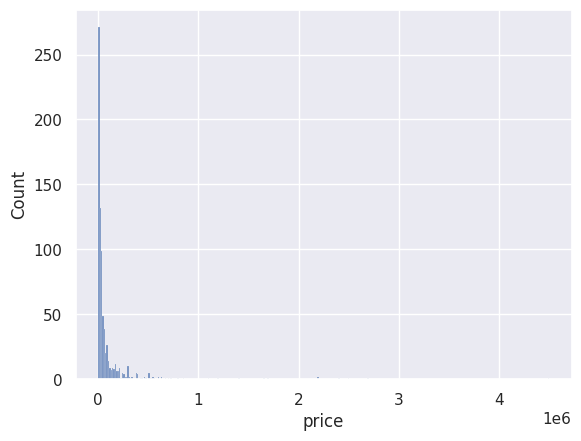

In [5]:
sns.histplot(data = df, x = 'price') ##the usual counting skew, theres 11 mares who went for over a million and look outliers

<Axes: xlabel='log_price', ylabel='Count'>

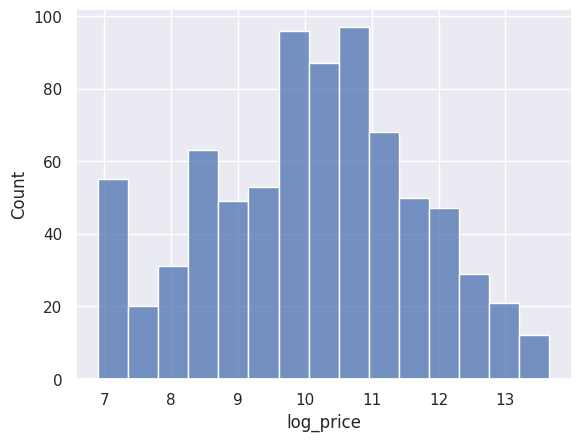

In [6]:
##going to remove the mares that went for over a million, they look be outliers.
df_2 = df.loc[df['price'] < 1000000] ##theres 11 removed here in decemeber 2023
df_2['log_price'] = np.log(df_2['price']) ##this looks to remove the not sold lots. hard to know if thats ok or not. will run with this for a while anyway.
sns.histplot(data = df_2, x = 'log_price') ##as usual data is more distributed now.

#### code on renaming df's i have created df_2 here as i filtered log price. as log price is our target variable and the variable we will be plotting its easier to remove it now. There is no need to remove the predictor variables as we go. I will take a note of what i think is best and creat a df_3 (prob will be named model df or something like that).

<Axes: xlabel='log_price', ylabel='Count'>

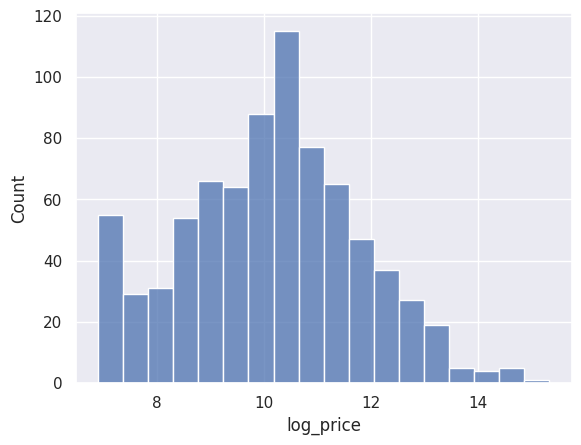

In [7]:
df['log_price'] = np.log(df['price'])
sns.histplot(data = df, x = 'log_price') ##can see the tail is skewed with the million pound mares in there, so will stick without them.

## Horse Age

<Axes: xlabel='horse_age'>

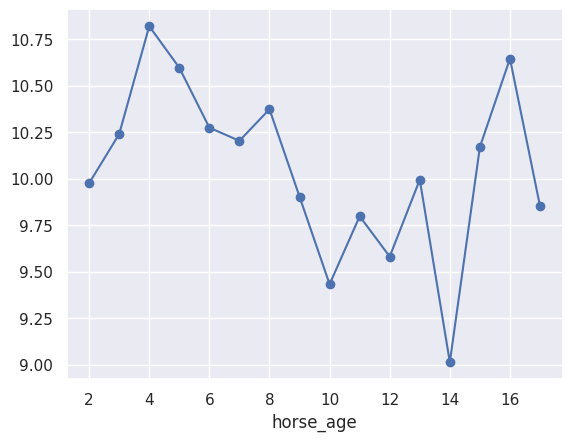

In [8]:
df.groupby('horse_age')['log_price'].median().plot(marker = 'o') ## would look to be a order 3 fit.

<Axes: xlabel='horse_age'>

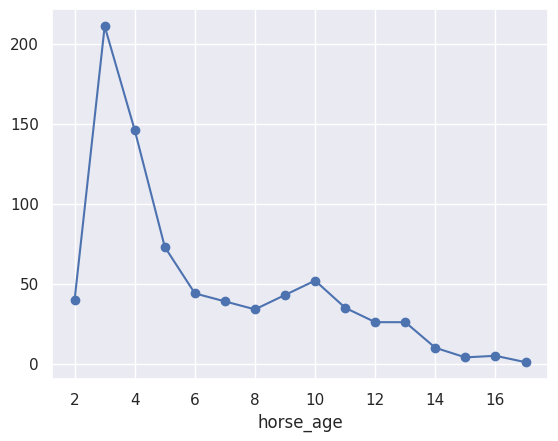

In [9]:
df.groupby('horse_age')['log_price'].count().plot(marker = 'o') ##sample is reduced as you go up in age. i have a suspision 2 models are needed for mares below a certain age. i think an overlap between 10 and 12 yr olds

<Axes: xlabel='horse_age', ylabel='price'>

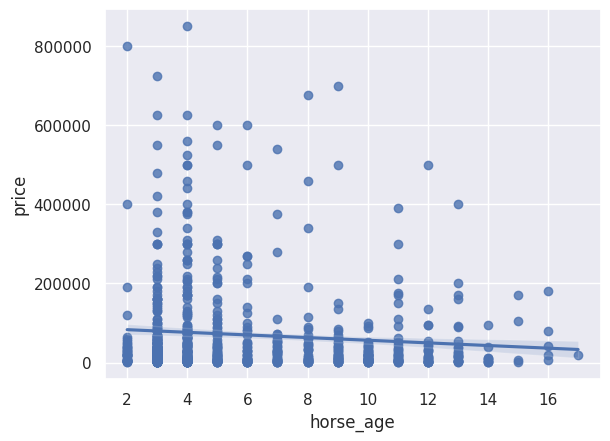

In [10]:
##a basic plot from the get go.
sns.regplot(data = df_2, x = 'horse_age', y = 'price')

<Axes: xlabel='horse_age', ylabel='log_price'>

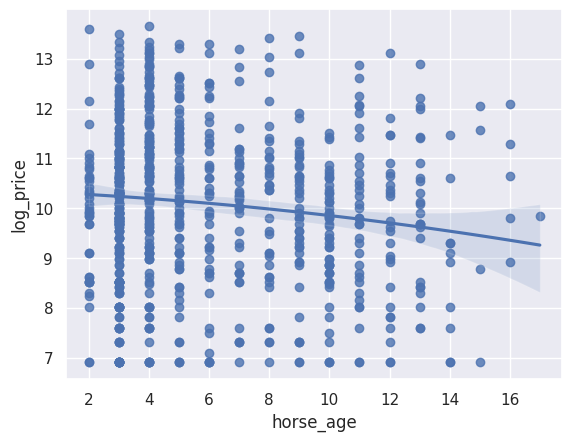

In [11]:
sns.regplot(data = df_2, x = 'horse_age', y = 'log_price', order = 2)

<Axes: xlabel='horse_age', ylabel='log_price'>

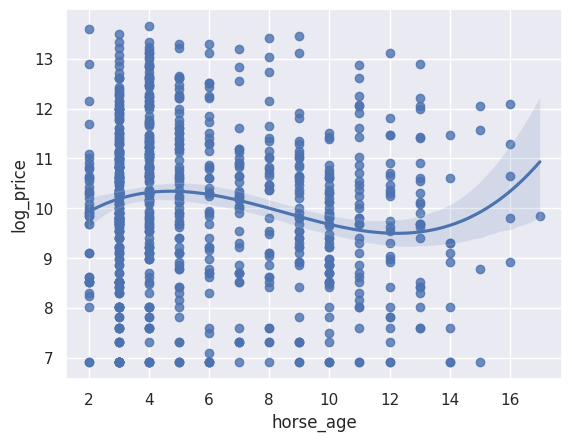

In [12]:
sns.regplot(data = df_2, x = 'horse_age', y = 'log_price', order = 3) #based on the median price by age plot order 3 would look the most suitable

### Horse Age Notes

Mares in the sale over the age of 12 starting going up in price. at this stage of thier lives the poor ones dont remain. theyve been around for long enough, I think metrics involding progeny should be weighted heavier for these mares as well. I suspect the market is based on this as well.

## Prog Ratings

In [13]:
##for younger mares will get ther racing stats and thier dams progeny stats
#will start by just getting the stats for all the lots on offer.

prog_form_basic_df = all_data_sets['prog_form_basic']
prog_form_basic_df = prog_form_basic_df.loc[prog_form_basic_df['mainType'] == 'FLAT']
prog_form_basic_df.head()

,mainType,horseUid,horseName,styleName,countryOriginCode,horseYob,horseSexCode,trainerName,trainerUid,runs,...,bestRpPostmark,avgFlatWinDistOfProgeny,distanceYard,distanceFurlong,winPercent,stakesWinnerOrPlaced,sale_lot_no,relationship,url_name,url
0,FLAT,4348708,Rockin Rosa,Rockin Rosa,GB,2020,F,Ruth Carr,20045,14,...,60.0,7.2,1554,7.0,7,False,1290,prog_basic_form,rockin-rosa,https://www.racingpost.com/profile/horse/43487...
1,FLAT,2985900,Lovely Rosie,Lovely Rosie,GB,2017,M,Harry Dunlop,18734,1,...,54.0,6.8,2084,9.5,0,False,1290,prog_basic_form,lovely-rosie,https://www.racingpost.com/profile/horse/29859...
2,FLAT,5063637,Phone Tag,Phone Tag,GB,2021,G,Hugo Palmer,25009,7,...,77.0,6.3,1791,8.0,14,False,1291,prog_basic_form,phone-tag,https://www.racingpost.com/profile/horse/50636...
3,FLAT,4076225,Magnificent Millie,Magnificent Millie,GB,2020,F,Harry Dunlop,18734,5,...,55.0,6.2,1332,6.0,0,False,1291,prog_basic_form,magnificent-millie,https://www.racingpost.com/profile/horse/40762...
4,FLAT,2826813,Faccio Io,Faccio Io,GB,2017,M,Grizzetti Galoppo SRL,34983,3,...,94.0,7.2,1760,8.0,33,True,1296,prog_basic_form,faccio-io,https://www.racingpost.com/profile/horse/28268...


In [ ]:
sns.lmplot(data = prog_form_basic_df, x = 'runs', y = 'bestRpPostmark') ## clear to see that runs effects bestrpmark. will also remove the shit 0's

In [ ]:
sns.lmplot(data = prog_form_basic_df.loc[prog_form_basic_df['runs'] <10], x = 'runs', y = 'bestRpPostmark')

In [ ]:
sns.lmplot(data = prog_form_basic_df.loc[prog_form_basic_df['runs'] >10], x = 'runs', y = 'bestRpPostmark')

In [ ]:
prog_form_stats = prog_form_basic_df.loc[prog_form_basic_df['bestRpPostmark'] > 0 ].groupby('sale_lot_no')['bestRpPostmark'].agg({'mean','count'}).reset_index().rename(columns = {'mean':'mean_prog_rating', 'count':'count_prog_rating'})
prog_form_stats.head()

In [ ]:
df_2 = df_2.merge(prog_form_stats, how = 'left', on = 'sale_lot_no')
df_2.head()

In [ ]:
sns.lmplot(data = df_2, x = 'mean_prog_rating', y = 'log_price') ##wonder is a 2nd order model the best

In [ ]:
sns.lmplot(data = df_2, x = 'mean_prog_rating', y = 'log_price', order = 2) ## hasnt changed much at all.

#### RP rating is effected by number of runs. the more the better. have removed the few poor outliers.

I should prob get stats on mares that do it quick, no need to include in model or anything but would be handy to see what pages things are happening quickly in. This is something to take into account when modeling mare ability (i.e scrape tatts december 2018 lets say and use past data to present the future (next 5/6 years which will be scraped in the full form sections)

could look at another metric now. and thats %above 80,90,100 etc

## Mare Rating

In [ ]:
own_sib_form_basic_df = all_data_sets['own_sib_form_basic']
mares_names = sale_df['horse_style_name']
own_form_basic_df = own_sib_form_basic_df.loc[own_sib_form_basic_df['horseName'].isin(mares_names)]
own_form_basic_df = own_form_basic_df[own_form_basic_df['mainType'] == 'FLAT']
own_form_basic_df.head()

In [ ]:
df_2 = df_2.merge(own_form_basic_df[['sale_lot_no', 'bestRpPostmark', 'stakesWinnerOrPlaced', 'horseName']], how = 'left', left_on = ['sale_lot_no', 'horse_style_name'], right_on = ['sale_lot_no', 'horseName']).drop(columns = {'horseName'})
##had to merge on horseName as well due to the fact lots had siblings in the sale. lot 1330 had 3 siblings in the sale who all raced (she didnt race herself ironically but there was 3 entries with rpRatings for her as a result, dropped the horseName column for tidyness afterwords)
df_2.head()

In [ ]:
sns.lmplot(data = df_2.loc[df_2['bestRpPostmark'] > 0], x = 'bestRpPostmark', y = 'log_price', hue = 'stakesWinnerOrPlaced') ##removing poor runs/incomplete data, there was a mare with a stake place but best RPR of 0
##stakes placed mares go for more then mares who arent staked placed. look at the 80 rating mark. the orange is above the blue.

In [ ]:
sns.regplot(data = df_2.loc[df_2['bestRpPostmark'] > 0], x = 'bestRpPostmark', y = 'log_price', order = 2) #possibly a better fit.

looking without removing the outliers.

In [ ]:
sns.lmplot(data = df_2, x = 'bestRpPostmark', y = 'log_price') ##potential an order 2 here

In [ ]:
sns.regplot(data = df_2, x = 'bestRpPostmark', y = 'log_price', order = 2) #would look better. other thing to think of is to strip out the poor mares below 40.
##if doing that will replace them with nans

### Mare rating notes

The mares rating matters it seems, im going to have a look at mares under 8 years of age to see if the slope is steaper.*italicized text*

In [ ]:
sns.lmplot(data = df_2.loc[df_2['bestRpPostmark'] > 34], x = 'bestRpPostmark', y = 'price') ##actually hasnt changed the slope much.

## Dam prog rating

In [ ]:
##for younger mares will get ther racing stats and thier dams progeny stats
#will start by just getting the stats for all the lots on offer.

own_sib_form_basic_df = all_data_sets['own_sib_form_basic']
own_sib_form_basic_df = own_sib_form_basic_df.loc[own_sib_form_basic_df['mainType'] == 'FLAT']
own_sib_form_basic_df.head()

In [ ]:
dams_prog_form_stats = own_sib_form_basic_df.loc[own_sib_form_basic_df['bestRpPostmark'] > 0].groupby('sale_lot_no')['bestRpPostmark'].agg({'mean','count'}).reset_index().rename(columns = {'mean':'dam_mean_prog_rating', 'count':'dam_count_prog_rating'})
dams_prog_form_stats.head()

In [ ]:
df_2 = df_2.merge(dams_prog_form_stats, how = 'left', on = 'sale_lot_no')
df_2.head()

In [ ]:
sns.lmplot(data = df_2, x = 'dam_mean_prog_rating', y = 'price') ##wonder is a 2nd order model the best

In [ ]:
sns.lmplot(data = df_2, x = 'dam_mean_prog_rating', y = 'price', order = 2) ## hasnt changed much at all.

The Progeny rating of the lots on offers siblings is effecting the price. The market is respecting mares who are out of dams that are good producers.

## Dam Rating

In [ ]:
dams_names = sale_df['dam_style_name']
print(len(dams_names))

In [ ]:
dams_aunt_uncles_form_basic_df = all_data_sets['dams_aunt_uncles_form_basic']
dams_aunt_uncles_form_basic_df = dams_aunt_uncles_form_basic_df.loc[dams_aunt_uncles_form_basic_df['mainType'] == 'FLAT']
dams_form = dams_aunt_uncles_form_basic_df.loc[dams_aunt_uncles_form_basic_df['horseName'].isin(dams_names)]
dams_form.head()

In [ ]:
df_2 = df_2.merge(dams_form[['sale_lot_no','bestRpPostmark', 'stakesWinnerOrPlaced', 'horseName']].rename(columns = {'bestRpPostmark':'dam_bestRpPostmark', 'stakesWinnerOrPlaced': 'dam_stakesWinnerOrPlaced'}), left_on = ['sale_lot_no', 'dam_style_name'], right_on = ['sale_lot_no', 'horseName'], how = 'left')
df_2 = df_2.drop(columns = {'horseName'})
df_2.head()

In [ ]:
sns.lmplot(data = df_2, x = 'dam_bestRpPostmark', y = 'price')

In [ ]:
sns.lmplot(data = df_2, x = 'dam_bestRpPostmark', y = 'price', hue = 'dam_stakesWinnerOrPlaced')

### dams rating notes

The rating dams of the mares on offer doesnt seem to effect price on the whole. Also the dam being blacktype doesnt seem to help much either.

**Another thing to consider is mares less then 8ish years of age? thier ability has to matter more to my intuition.**

In [ ]:
sns.lmplot(data = df_2.loc[df_2['horse_age'] <=8], x = 'dam_bestRpPostmark', y = 'price')

In [ ]:
sns.lmplot(data = df_2.loc[df_2['horse_age'] <=8], x = 'dam_bestRpPostmark', y = 'price', hue = 'dam_stakesWinnerOrPlaced')

The dam rating does not effect the price even for younger mares! Blacktype is similar to my eye.

## Dam Sires and Sires Of Dams Sire Stats


In [ ]:
dam_sire = all_data_sets['dam_sire_stats']
dam_sire.head()

In [ ]:
df_2 = df_2.merge(dam_sire[['sale_lot_no', 'dam_sire_mean_rating', 	'count_dam_sire_x', 'dams_dam_sire_mean_rating','count_dam_sire_y']], on = 'sale_lot_no', how = 'left') #im filtering out the sires names fro now. this is to make the df easier to view.
df_2.head()

In [ ]:
sns.lmplot(data = df_2.loc[df_2['count_dam_sire_x'] >= 40], x = 'dam_sire_mean_rating', y = 'log_price') ## bit of a slop, no huge correlation.

In [ ]:
sns.lmplot(data = df_2.loc[df_2['count_dam_sire_y'] >= 40], x = 'dams_dam_sire_mean_rating', y = 'log_price') #slope is less. looks to be little correlation.

##Sales
Horse Sales is hard to deal with. I think the best approach might be to judge horses on there max sales. I can also isolate foals/yearlings. Its very hard to know atm. will have to try get a clearence rate in there as well.

so potential metrics here

*   %sold of yearlings/foals
*   just look at yearlings maybe
*   simple but top selling price? the more recent the better.


###Prog Sales

In [ ]:
prog_sales_df = all_data_sets['prog_sales']
prog_sales_df['id'] = prog_sales_df['damName'].astype(str) + "_" + prog_sales_df['horseYob'].astype(str) #creating an id that individualises the horses sales
prog_sales_df.head()

In [ ]:
#going with max price for now
index = prog_sales_df.groupby('id')['priceGbp'].idxmax().dropna()
max_price = prog_sales_df.loc[index][['priceGbp','sale_lot_no','horseAge']]
median_max_price = max_price.groupby('sale_lot_no')['priceGbp'].agg({'median', 'count'}).reset_index().rename(columns = {'median': 'median_best_prog_price', 'count': 'count_prog_sold'})
median_max_price

In [ ]:
df_2 = df_2.merge(median_max_price, how = 'left', on = 'sale_lot_no')
df_2.head()

##dams prog sales - important to strip the mares themselves out too.

can then create a new metric where thier previous highest sale counts


In [ ]:
own_sib_sales_df = all_data_sets['own_sib_sales']
own_sib_sales_df['id'] = own_sib_sales_df['damName'].astype(str) + "_" + own_sib_sales_df['horseYob'].astype(str) #creating an id that individualises the horses sales

##for the december sale i am going to take out sales after december. the mares themselves data would be in there.
own_sib_sales_df_pre_sale = own_sib_sales_df.loc[own_sib_sales_df['saleDate'] < '2023-11-30']

#splitting into siblings
dam_names = own_sib_sales_df['damName'].to_list()
own_sales_df = own_sib_sales_df_pre_sale.loc[own_sib_sales_df_pre_sale['horseName'].isin(dam_names)] #sale data for the lots on offer themselves
sib_sales_df = own_sib_sales_df_pre_sale.loc[~own_sib_sales_df_pre_sale['horseName'].isin(dam_names)] ## there sibling sales
##numbers add up for the right amount of lots sold anyway.

In [ ]:
#going with max price for now and taking the dams themselves out
index = sib_sales_df.groupby('id')['priceGbp'].idxmax().dropna()
max_price_sib = sib_sales_df.loc[index][['priceGbp','sale_lot_no','horseAge']]
median_max_price_sib = max_price_sib.groupby('sale_lot_no')['priceGbp'].agg({'median', 'count'}).reset_index().rename(columns = {'median': 'median_dams_best_prog_price', 'count': 'count_dams_prog_sold'})
median_max_price_sib.head()

In [ ]:
max_price_own = own_sales_df.groupby('sale_lot_no')['priceGbp'].max().rename('max_mare_price').reset_index()
max_price_own.head() ##mares own sale price here

In [ ]:
df_2 = df_2.merge(median_max_price_sib, how = 'left', on = 'sale_lot_no').merge(max_price_own, how = 'left', on = 'sale_lot_no')
df_2.head()

In [ ]:
##will create the log of the best prices for fitting the model
df_2['log_median_best_prog_price'] = np.log(df_2['median_best_prog_price'])
df_2['log_median_dams_best_prog_price'] = np.log(df_2['median_dams_best_prog_price'])
df_2['log_max_mare_price'] = np.log(df_2['max_mare_price'])
df_2.head()

In [ ]:
df_2.count()

###Variable anaysis notes

when looking at mares bestRPrating in EDA I stripped out the 0's. best to replace them with nans when building the model.

# Correlation Analysis X log_price

The nice thing about the below function is that its easy to see the variabls with the highest correlation. I can come up with better sales stats or progeny stats later and quickly see do they improve the correlation with log_price. alot of the exploritory analsis i was doing was essentially trying to establish this but in hind sight was prob a bit over the top for now. That analsis style will be usefull when looking back at a sale from 5 years ago and coming up with models to predict the ability of a broodmare.

In [ ]:
df_2.head()

In [ ]:
######should filter by age. can get a load of different df's here after filtering the data i want. it will test my theorys strong. potential game changer here.
#chuffed with that tought, will save plenty of time doing exploritory analysis
df_2.drop(columns = {'horse_style_name','sire_style_name','dam_style_name','sire_of_dam_style_name'}).corr()['log_price'].sort_values()

### Correlation Notes



*   Top Metrics atm is prog sales, dams prog sales is high too (have to be careful here as the mares themselves will be bundled in there too, should really strip them out.
*   mean_prog_rating is the 2nd highest - like above the dams prog mean is good too but a touch less then the mare itself
*   sale_lot_no is significant too. its negetive indicating the quality of the sale decreases as the sale goes on.
* the mares bestRPPostmark is correlated as well.
* horse age not too correlated to log price but it is a touch - I cant wait to loop over age and get different correlations to price based on the age of the mare.
* like age the dam sire stats are a touch correlated but not much so.



### corelation by mare age

In [ ]:
correlation = pd.DataFrame()
for i in range(2,17):
  data = df_2.drop(columns = {'horse_style_name','sire_style_name','dam_style_name','sire_of_dam_style_name'}).loc[(df_2['horse_age'] >= i) & (df_2['horse_age'] >= i +4)]
  x = data.corr().filter(items = ['log_price'], axis = 0)
  upper = i + 4
  x.index = [str(i) + "-" + str(upper)]
  correlation = correlation.append(x)
correlation.head()

In [ ]:
###fairly sure iv left out a column here that might be usefull. will recheck later
correlation[['mean_prog_rating', 'bestRpPostmark', 'dam_mean_prog_rating', 'dam_bestRpPostmark', 'dam_sire_mean_rating', 'dams_dam_sire_mean_rating', 'log_median_best_prog_price', 'log_median_dams_best_prog_price', 'log_max_mare_price']].plot(marker = 'o').legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

In [ ]:
df_2.groupby('horse_age')['log_price'].count();

## Corelation Analysis
The metric correlation surprsingly doesnt change that much. The correlation metrics get wild for mares older then 12. I suspect this could be a sample size thing as well as the mares at that level getting old and prob have something standing out on there page that is open to variance such as being closely related to a top level performer etc. Not only does the variance look to be larger for older mares but the change in slopes doesnt make much intuitive sences. **Anyway to summarise correlation represents how much accuarcy each metric has when predicting the target variable and doesn indicate really how much weight the market has assigned to each metric**. I will try look at the slopes next and see do they change with age.

#Slopes Of Regression Lines (Finding most significant variables) X Log_price

## Slopes by mare age

In [ ]:
data = df_2[['mean_prog_rating', 'bestRpPostmark', 'dam_mean_prog_rating', 'dam_bestRpPostmark', 'dam_sire_mean_rating', 'dams_dam_sire_mean_rating', 'log_median_best_prog_price', 'log_median_dams_best_prog_price', 'log_max_mare_price','log_price', 'horse_age']]
y = data['log_price']
x = data[['mean_prog_rating', 'bestRpPostmark', 'dam_mean_prog_rating', 'dam_bestRpPostmark', 'dam_sire_mean_rating', 'dams_dam_sire_mean_rating', 'log_median_best_prog_price', 'log_median_dams_best_prog_price', 'log_max_mare_price','horse_age']]
data.dropna().shape ##there is only 122 mares that have complete data across the above metrics. this isnt a good sample size. its prob best to try and build sub models for now.

In [ ]:
x.isna().sum().sort_values()

we can see that prog rating and prog price contain the most nans, these columns are prob best saved for building a model with older mares as i suspect by age the ratio of nans will decrease for progeny metrics as the mares get older.

##### Indivual variable Correlation X Log Price

In [ ]:
def variable_slope_horse_age(variables):
  all_variables = variables + ['log_price', 'horse_age']
  model_data = df_2[all_variables].dropna()##dropping nans
  x1 = model_data[variables]
  y = model_data['log_price']

  coefficients = pd.DataFrame()
  for i in range(2,13):
    upper = i + 4
    data = model_data.loc[(model_data['horse_age'] >= i) & (model_data['horse_age'] >= upper)]
    x1 = data[variables]
    y = data['log_price']
    model = LinearRegression()
    model.fit(x1, y)

    r2_score = model.score(x1, y)
    coef = pd.DataFrame(model.coef_, index = [variables], columns = [str(i) + "-" + str(upper)]).transpose()
    coef['sample_size'] = data.shape[0]
    coef['r_squared'] = r2_score

    coefficients = coefficients.append(coef)

    #print(i, "-", upper, '\n', f"R-squared value: {r2_score}", '\ncoefficients  below', coef, '\n')
  coefficients[variables].plot(marker = 'o').legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
  #print(coefficients)
  return coefficients

variables = ['bestRpPostmark','dam_bestRpPostmark']
test = variable_slope_horse_age(variables)

##### All variables in one model - Slopes

In [ ]:
variables = x.columns.to_list()
variables.remove('horse_age')
all_variables= variable_slope_horse_age(variables)

In [ ]:
all_variables ## table of coefficents when including them in one big model. laws of averages and signs of multicolinearity in there for me

## Linear Model by age - All Variable conclusions

It doesnt make a huge pile of sense. There must be colinearity as some variables that are positively correlated with log_price are negetive when put in the above model. The models slopes get wilder the older the mares are. The samples are also small so I have to take them with a pinch of salt. Overall I will just treat mares as the same age for now. And build a model with age as a predictor variable for now. **I should now look at each variable individually - I wonder is multicoliearity getting in the way here as some strong variables look weaker here**


### Linear Model by age - Individual Variable Slopes
very similar to above except that we are looking at variables individually compared to log_price rather then as one big model.

In [ ]:
variables = x.columns.to_list()
variables.remove('horse_age')
ind_coef = pd.DataFrame()
for i in variables:
  print(i)
  test = variable_slope_horse_age([i])
  ind_coef = pd.concat([ind_coef, test.iloc[:,0]], axis = 1);

some make sense and some dont. The ends of the graphs sample sizes will have been very small in some cases I suspect. cant really draw too many conclusions here. Will try a similar process to above except have horse age as a predictor variable, was well worth examining the above and is possibly somethign to reconsider when more data is in. Have included the stats of the model below for context later

In [ ]:
ind_coef #individual coefficients ###note these coefficients are different to the df a few cells above as these coefficents are generated from the predictor vairable on its own rather then one big model with all variables included.

In [ ]:
ind_coef.mean().sort_values()#having a look to see what coefficients have the biggest slopes. will look at absolute values

## Individual Variable coefficients by age - Conclusion

christ it just gets more and more baffling. dam sire is now a big variable it seems. and the prog price has no impact for both generations, how can that be. it would be a massive variable intuatively.**Im going to look at all there varibales individually anyway** Looking at them individually will increase sample size for a lot of the variables. I have included the model r score below for context later.

##### All Variables in a linear model - Model Stats

In [ ]:
model_data = data.dropna()##dropping nans
y = model_data['log_price']
x1 = model_data.drop(columns = {'log_price','horse_age'})

model = LinearRegression()
model.fit(x1, y)

r2_score = model.score(x1, y)
print(r2_score) ##model has been decimated by nans r2 score is as high as ever tough. but will take that with a pinch of salt. have nearly as many columns as rows which is shambles

### above is pretty useless rigth now - **Code will be useful for when I have more data**

# Building a model - Age Included in the model
will start by seeing all variables relationship with log_price, this model will have age as a predictor variable rather then a "filter variable"

In [ ]:
def variable_slope(variables):
  all_variables = variables + ['log_price']
  model_data = df_2[all_variables].dropna()##dropping nans
  x1 = model_data[variables]
  y = model_data['log_price']

  coefficients = pd.DataFrame()
  model = LinearRegression()
  model.fit(x1, y)
  r2_score = model.score(x1, y)
  coef = pd.DataFrame(model.coef_, index = [variables], columns = ['coeficient']).transpose()
  coefficients = coefficients.append(coef)

  #print(i, "-", upper, '\n', f"R-squared value: {r2_score}", '\ncoefficients  below', coef, '\n')
  #coefficients[variables].plot(marker = 'o').legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
  #print(coefficients)
  return coefficients

variables = ['bestRpPostmark','dam_bestRpPostmark']
test = variable_slope(variables)

In [ ]:
variables = x.columns.to_list()
ind_coef = pd.DataFrame()
for i in variables:
  test = variable_slope([i])
  ind_coef = pd.concat([ind_coef, test.iloc[:,0]], axis = 1);
ind_coef = ind_coef.transpose().sort_values('coeficient')
ind_coef

**The above shows how important the sales price are for a mares selling price**. Thier progenys best price has the highest slope by a distance. The other 2 price variabels are streets clear of the rest as well. The slopes here will need context as I have taken logs etc and compared to age are very different scales I suspect. I will continue now by looking at what sales columns have the most data so that I can build a model using the most data.

In [ ]:
###reminder of the correlation with log_price.
pd.DataFrame(df_2.corr()['log_price'].sort_values())

In [ ]:
x.shape

## Selecting Metrics To Include In Model

In [ ]:
x[['log_max_mare_price', 'log_median_dams_best_prog_price', 'log_median_best_prog_price']].count()

The 3 things im looking at here when deciding on which price to use is the 1.sample size - dams prog wins here comfy. The 2.slopes of the variables - mares progeny price wins here and it wins the 3.correlation. Its a shame about the sample size, it goes to show how important the mares progeny stats are when the data is avialable tough and is the takeaway here for when predicting a mares price. **For this model I will go with the larger sample as the data will be getting more and more reduced as we go.**


In [ ]:
x[['dam_bestRpPostmark', 'bestRpPostmark']].count() #similar counts so can go with correlation and slope as the main variables. #bestRPpostmark has a much stronger correlation to price and has a larger slope.

Sample size is as good as a tie. bestRpPostmark is much more significant in terms of slope and has a stronger correlation.

In [ ]:
x[['dam_mean_prog_rating','mean_prog_rating']].count() #there is a big count difference here. mean_prog_rating will have to be very strong.  Im going to have to go with the larger sample regardless, in this instance anyway the dams_mean_prog_rating has a larger slope.
#and there wasnt much between the correlation either. good producing dams seem to be as equally correlated to price as the mares themselve in this sample.

other variables to explore that are in the dataset is the **dam sire stats**. The slopes are half that of the progeny rating stats lets say so they could be significant. but I will build a handy model using the 3 variables i have picked out so far.

The 3 price variables look hugely signifcant, I have picked out the one with the largest sample size right now. I have picked out 2 rating metrics, the prog rating (dams) and the animal producing rating (mares themselves). Of the 2 it is interesting looking at the slopes that the market weights the producing ratings heavier then the mares rating.

#Model

In [ ]:
model_data = data[['log_price','dam_mean_prog_rating','bestRpPostmark','log_median_dams_best_prog_price','horse_age']].dropna()##dropping nans
y = model_data['log_price']
x1 = model_data.drop(columns = {'log_price'})

model = LinearRegression()
model.fit(x1, y)

r2_score = model.score(x1, y)
print(r2_score)## model scores poorly when only using the 4 variables above. I suspect our other models score would have been very inaccurate.

In [ ]:
model.coef_

In [ ]:
##will throw in damsire stats now. nice to include as they are on the same scale as the rating and prog rating divisions
x[['dam_sire_mean_rating', 'dams_dam_sire_mean_rating']].count() ## similar sample size. dams_dam_sire rating is slopped steaper and the correlation is a par. with a touch larger sample its the one to go for here.
#going forward with more data I suspect the generation below is the one to include

In [ ]:
model_data = data[['log_price','dam_mean_prog_rating','bestRpPostmark','dams_dam_sire_mean_rating','log_median_dams_best_prog_price','horse_age']].dropna()##dropping nans
y = model_data['log_price']
x1 = model_data.drop(columns = {'log_price'})

model = LinearRegression()
model.fit(x1, y)

r2_score = model.score(x1, y)
print("r_sqr value:", r2_score, "\nIntercept:", model.intercept_, "\nCoefficients:", model.coef_)## model scores less, could nearly not include it really. it will be interesting to look into the coefficients as they are the biggest takeaways reletive to each division from this sample I think.

#### Model Conclusions

#### Best Metrics
The above model is not very accurate is the main takeaway. That is a shame but shows there is plenty of variance out there. I am a step closer to being able to figure out how to value a mare on average based on the data points that I monitor.




#### Breaking down the ceoficients and what they mean for sale price.


*   log_median_dams_best_prog_price - For every 25% increase in the median dams best price there will be a (1.25^0.281 -1) * 100 percent increase in mare price. I.e 6.5% increase in mare price.
*   deam_mean_prog_rating - We take the expotential of the coefficent to see the effect on mare price. For every 1lb increase in mean_prog_rating there is a 4.5% increas in mare price.




### Insights

1.   **Prog Ratings Division is weigthed the heaviest of the 3 ratings divisons** (Prog Rating, Dam Sire Rating and Mare Rating)- I suspect the mares prog generation will be the most accurate/weighted heaviest in time.
2.   **The most important variable is the sale price area**. Of that the mares is the best going forward, I didnt really have a large enouhgh sample size above.
3.   The Interecept of the above models suggests that the majority of the metrics are positive which they are. Bar Horse Age everything is positively correlated.



# Quick look at categorical Variables.

At this stage I am not looking to build the most accurate model, rather I will just examine the effect the following metrics have on mare price while trying to control for something like rating.

In [ ]:
df_2= df_2.merge(sale_df[['sale_lot_no','sale_date']], on = 'sale_lot_no', how = 'left')
df_2.head()

In [ ]:
sale_day = df_2['sale_date'].drop_duplicates().reset_index().drop(columns = 'index').reset_index().rename(columns = {'index': 'sale_day'})
df_2 = df_2.merge(sale_day, on = 'sale_date', how = 'left')
df_2['sale_day'] = df_2['sale_day'] + 1
df_2.head()

In [ ]:
df_c = df_2[['sale_day', 'stakesWinnerOrPlaced', 'dam_stakesWinnerOrPlaced','log_price', 'dam_mean_prog_rating']] #went with dam prog ratigns here as the sample is larger
df_c.head()

In [ ]:
df_c.count()

### Sale Day

In [ ]:
sns.lmplot(data = df_c, x = 'dam_mean_prog_rating', y = 'log_price', hue = 'sale_day') ## went with this style plot as the quality of mares is clearly differnt on sale day. making a box plot inacurate imo.

### BlackType

In [ ]:
sns.lmplot(data = df_c, x = 'dam_mean_prog_rating', y = 'log_price', hue = 'stakesWinnerOrPlaced') ##again went with this style as mares with blacktype are on average going to be rated higher then those without. making a box plot inaccurate imo.

In [ ]:
sns.lmplot(data = df_c, x = 'dam_mean_prog_rating', y = 'log_price', hue = 'dam_stakesWinnerOrPlaced')

## Categorical Variable conclusion



*   The day of the sale looks to effect price. When you control for dams_prog_rating. The graph makes sense as well. Day 2 is always the best and it gets worse from there, day 1 is always the 2nd best.
*   **Black type for the mares on offer is very overvalued - Its silly, this is only an edge for us if it doesnt effect foal price tough.** For now tough you would avoid mares with B.T anyway. The dams of the mares haveing blacktype is irrelevent compared to sale price in this sale anyway.



#Extend selective model with Categorical variables included.

wont be including dam black type as that looks irrelevent.


In [ ]:
df_2[['mare_bt_True']] = pd.get_dummies(df_2['stakesWinnerOrPlaced'], drop_first = True)##dropping first column despite nans as will be removing all dans from df before building model
df_2[['day2', 'day3', 'day4']] = pd.get_dummies(df_2['sale_day'], drop_first = True)
df_2.head()

In [ ]:
df_2[['mare_bt_True','stakesWinnerOrPlaced']].head(5)

In [ ]:
x1.columns #these are the columns from the selective model built earlier

In [ ]:
columns = x1.columns.to_list() + ['log_price'] + ['mare_bt_True'] + ['day2', 'day3', 'day4']
model_data = df_2[columns]
model_data.head()

In [ ]:
model_df = model_data.dropna()
model_df.shape

In [ ]:
y = model_df['log_price']
X = model_df.drop(columns = {'log_price'})

model = LinearRegression()
model.fit(X, y)

r2_score = model.score(X, y)
print("r_sqr value:", r2_score, "\nIntercept:", model.intercept_, "\nCoefficients:", model.coef_)# r squared is much better now for including the extra categorical variables.

In [ ]:
coef = pd.DataFrame(model.coef_, index = [X.columns], columns = ['coeficient']).transpose()
coef #### the below rounds to 2 decimals which is very unaccuarate for this model.

#### Final Model Conclusions

#### Best Metrics
The above model is a lot more accurate then the first one built. The categorical variables have made a big difference it seems. To my eye im happier with the intercept (not a thing really but just looks better to me).


#### Breaking down the ceoficients and what they mean for sale price.


*    categorical variable - mares_bt (0.72) - means for a mare with blacktype the sale price will be exp(0.72) = 2.05 times that for a mare without blacktype. That would seem a bit extreme to my eye especially when we looked at the above plots but its shows how significant the market values blacktype, this an over plyed edge. It will be worth looking into does it translate to foal prices, if not then there is an edge in here.



### Insights

1.   **Prog Ratings Division is weigthed the heaviest of the 3 ratings divisons** (Prog Rating, Dam Sire Rating and Mare Rating)- I suspect the mares prog generation will be the most accurate/weighted heaviest in time.
2.   **The most important variable is the sale price area**. Of that the mares is the best going forward, I didnt really have a large enouhgh sample size above.
3.   Mares Blacktype is effecting sales price. I should look into if this being transerred into the foal market when I get a chance. This should be an adhoc experiment, scrape the basic json for a few foal sales. use dam rating or some similar metric as the control. I suspect though this is an edge we can use to our favour. for all the markets poor judgment here will be rewarded in the foal market. **The effect is quite large nearly double the price controlling for all other variables. ** Im taking that with a pinch of salt but it shows the significance of the variable anyway.
4. Day of sale is a factor too. There will be solid mares in day 3 and 4 with good stats that will go for less then mares earlier in the week.

## Important Conclusion
I imagine the sale day variables made a big difference to the model accuracy. As the sale is select there would have been a human deciding what day the mares are offered on. So its not so simple as lb for lb shop on day 3 or day 4 but given the jump in coefficients there will defo be mares that slip through the cracks. My feeling for days like this is there will surely be mares with solid metrics that can be found at great value.

#Predictive Model

Using the findings from above I will build a predictive model and analise the residuals.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 3)
reg = LinearRegression()
reg.fit(X_train, y_train) # fitting a linear model on our training datasets. using the variables in the x_train dataset to model the target variable in the y dataset (rating_final)
y_pred = reg.predict(X_test) # produces the predictions the model would make on our test dataset.
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
regression_results(y_test, y_pred) ## happy with those stats.

In [ ]:
coefficients = pd.concat([pd.DataFrame(X.columns, columns = ['variable']),pd.DataFrame(np.transpose(model.coef_), columns = ['coefficents'])], axis = 1)
coefficients.sort_values('coefficents')

In [ ]:
y_pred_series = pd.Series(y_pred - y_test + y_test)
prediction = pd.concat([y_test.rename('actual'), y_pred_series.rename('predicted')], axis = 1)
sns.lmplot(data = prediction, x ='predicted', y = 'actual') ## the erorrs look somewhat evenly spread around the line of best fit. perhaps a bit ider towards the upper end of the scatterplot.

In [ ]:
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot() ##happy with that residual plot

The scatterplpot suggested the residuals where ok, and the residual plot backs that up too.

## Model Improvement - No Joy

#### Cross Validation

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

kf = KFold(n_splits=10, shuffle=True, random_state=5) #created a kfold arguement that splits the data up into random samples 25 times, giving our model 25 differnt sets to validate its performance.
reg = LinearRegression()

# Compute 10 fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

print(cv_scores, "\nmean_cv_score:", cv_scores.mean(), ) #solid enough happy as I can be for now.

In [ ]:
cv_scores.min(), cv_scores.max()

### Adaboosting

In [ ]:
#taken from datacamp.
# Instantiate the default linear regression model
reg = LinearRegression()

# Build and fit an AdaBoost regressor
reg_ada = AdaBoostRegressor(base_estimator=reg, n_estimators=20, random_state=3) #setting number of estimators to 20. the algorithm will attempt to learn from the worse predictions of the previous model 20 times.
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

r_squared = reg_ada.score(X_test, y_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"R^2: {round(r_squared,3)}")
print(f"RMSE: {round(rmse,3)}") ### R^2 has gone down (bad) and RMSE has gone up (bad), adoboosting hasnt worked here.

In [ ]:
##fitting a dececion tree based model to the data to see can we improve the RMSE value again.
# Build and fit a tree-based AdaBoost regressor
reg_ada = AdaBoostRegressor(n_estimators=12, random_state=500) #default is decision tree so no need to fill out the parameter. max depth is set at 3 by default. number of estimators is set to 12.
reg_ada.fit(X_train, y_train)

# Calculate the predictions on the test set
pred = reg_ada.predict(X_test)

r_squared = reg_ada.score(X_test, y_test)

# Evaluate the performance using the RMSE
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"R^2: {round(r_squared,3)}")
print(f"RMSE: {round(rmse,3)}") #same as first adobooster

In [ ]:
##experimenting with different amount of estimators and learning rate. As there is a trade off between the 2 as I increase the learning rate I will decrease the amount of estimators.
RMSE = {}
RSQ = {}
for i,j in zip(np.linspace(10,100,10, dtype = int)[::-1], np.linspace(0.1,1,10)): #creates a for loop that iterates over 2 arrays of numbers. the 2nd arrays order is reversed by [::-1]
  # Build and fit an AdaBoost regressor
  reg_ada = AdaBoostRegressor(n_estimators= i, learning_rate = j, random_state=500) #dropped the learning rate down to 0.01 and increased the amount of estimators.
  reg_ada.fit(X_train, y_train)

  # Calculate the predictions on the test set
  pred = reg_ada.predict(X_test)

  # Evaluate the performance using the RMSE
  rmse = np.sqrt(mean_squared_error(y_test, pred))
  r_squared = reg_ada.score(X_test, y_test)

  RMSE[rmse] = [i,j]
  RSQ[r_squared] = [i,j]
  #print('RMSE: {:.3f}'.format(rmse))

col = ['RMSE','N_estimators', 'Learning_rate'] #setting the columns for the dataframe that we are going to covert the dictionary into.
rmse = pd.DataFrame.from_dict(RMSE, orient='index').reset_index()
rmse.set_axis(col, axis = 1, inplace = True)
rmse

In [ ]:
col = ['r_squared','N_estimators', 'Learning_rate'] #setting the columns for the dataframe that we are going to covert the dictionary into.
rsq_df = pd.DataFrame.from_dict(RSQ, orient='index').reset_index()
rsq_df.set_axis(col, axis = 1, inplace = True)
rsq_df

Across the board we arnt really getting anywhere with ado boosting our model. Can come back to it if the next dataset I use has a poor model.

# Notebook

Order of how to do things.

1.   compile and merge the metrics you think will be most usefull
2.   Build a model with the metrics you have. (I went down eda too soon and too detailed)


*   check the correlation and slopes - sample sizes etc
*   then did deeper into the variables. I.e best rating and filter out the 0's etc.


3.   Explain coefficients
4.   Build more models I think.

went down the fafgin route of adaoboosting but it doestn really help my finished model much


### Presentation - Conclusions are best with 2 hashtags and the title before hand with 1. if in doubt go with 3 or more.


**To Do**
lot_no by day. have a dig into if the first and last lots are lacking controlling for other variables. check to be sure that lots by day is random.

Notes:

I have no data on what stallions the mares where in foal too at the time of the sale. That could help boost model performance. Its something I could come back round too after doing my anayis on predicting mare ability.


Also the model that i built only covers mares with "complete data" I either need to fill nans or build more models to facilitate the other mares. The final model in this only priced something like 10% of the mares on offer.